In [3057]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.patches import Ellipse


#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 3d_ipm_env.ipynb #imports LIPM Env

[0.5 0. ] 0.4
[1. 0.] 100.4


In [3058]:
# Lipm - 8 layers , 512 each
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [3059]:
class DQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.00
        self.max_no = 5 #number of actions with non zero step in z
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            
        return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

In [3161]:
# This block is to compare cpature regions with analytical capture region
def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def infinite_capture_radius(step_time, max_step_length, ht):
    delta_t = np.sqrt(9.81/ht)*step_time
    return max_step_length*(np.power(np.e, -delta_t))/(1 - np.power(np.e, -delta_t))

def plot_heatmap_with_capture_region(x, next_x, terr, dqs, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs.predict_q(x, terr)[0]
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q_1)):
        q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    dcm_x = compute_dcm([next_x1[0], next_x1[3]], env.h)
    dcm_y = compute_dcm([next_x1[1], next_x1[4]], env.h)
    fig, ax = plt.subplots(figsize = (8,5))
    rad = infinite_capture_radius(0.2, env.action_space_x[-1], env.h)
    print(rad, dcm_x, dcm_y)
    discretization_x = env.action_space_x[1] - env.action_space_x[0]
    discretization_y = env.action_space_y[1] - env.action_space_y[0]
        
    capture_region = Ellipse(( dcm_x/discretization_x + 5, dcm_y/discretization_y), \
                                2*(rad//(discretization_x)), 2*(rad//(discretization_y)), fill = False, color = 'red', lw = 2.5)
    
    dcm = plt.Circle(( dcm_x/discretization_x + 5, dcm_y/discretization_y), \
                                0.15, fill = True, color = 'red')

    kin_region = Ellipse((next_x[0]/discretization_x + 6, next_x[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//discretization_y), fill = False, color = 'yellow', lw = 2.5)
    ax.add_patch(capture_region)
    ax.add_patch(kin_region)
    ax.add_patch(dcm)
    ax.set_xticklabels(env.action_space_x[::2])
    ax.set_yticklabels(env.action_space_y)
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    ax.set_xlim(0,11)
    ax.set_ylim(0,9)
    
    fig.colorbar(heatmap, ax=ax)
    plt.show()

# env.show_episode(5)
# env.show_episode_side(5)



In [3220]:
ht = 0.35
max_step_length = [0.4, 0.3]
no_actions = [11, 9]
env = InvertedPendulumEnv(ht, 0.13, max_step_length, [0.5, 3, 1.5], no_actions)
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)
print(env.action_space_x)
print(env.action_space_y)

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_1')
dqs_bullet = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_1_vel')


[11, 9]
[-0.4  -0.32 -0.24 -0.16 -0.08  0.    0.08  0.16  0.24  0.32  0.4 ]
[0.   0.04 0.09 0.13 0.17 0.21 0.27 0.34 0.43]


In [3225]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.2 ## time after which step is taken

v_init = np.round([0.2*random.uniform(-1.0, 1.0), 0.2*random.uniform(-1.0, 1.0)], 2)
v_des = [0.0, 0.0]
# v_init = [0.0, -0.0]
print(v_init)
state = env.reset_env([0.0, 0.00, ht, v_init[0], v_init[1]], v_des, no_steps*step_time)
epi_cost = 0
history = {'state' : [], 'action' : [], 'next_state' : []}
for n in range(no_steps):
    terrain = -0.00*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time)
    history['state'].append(state)
    history['action'].append(action)
    history['next_state'].append(next_state)
    print(action, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
        
# env.show_episode_side(10)


[-0.2   0.05]
[5, 5, -0.0] [-0.2   0.05]
[1, 1, -0.0] [-0.32  0.51]
[6, 4, 0.0] [-0.83  0.2 ]
[4, 2, -0.0] [-0.22  0.39]
[4, 1, 0.0] [-0.4  -0.08]
[3, 4, -0.0] [-0.53 -0.03]
[2, 3, 0.0] [-0.77 -0.3 ]
[5, 1, -0.0] [-0.87  0.2 ]
[4, 4, -0.0] [-0.42  0.07]
[4, 4, 0.0] [-0.49  0.3 ]


0.21242407797540092 -0.11044348503166143 0.28133180426921045


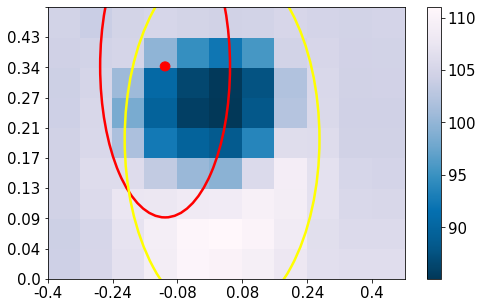

0.21242407797540092 -0.11044348503166143 0.28133180426921045


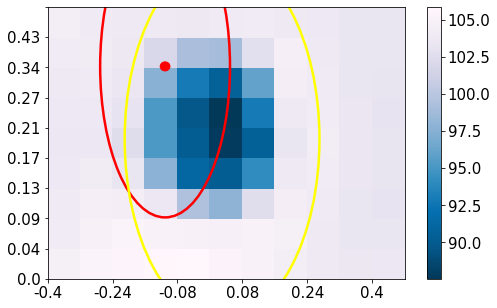

In [3226]:
i = 0
x1 = history['state'][i].copy()
next_x1 = history['next_state'][i].copy()
next_x1[0] += env.action_space_x[int(history['action'][i][0])]
next_x1[1] += x1[5]*env.action_space_y[history['action'][i][1]] + 0.13/2.0

terrain_1 = -0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0
plot_heatmap_with_capture_region(x1,next_x1, terrain_1,dqs, env)
plot_heatmap_with_capture_region(x1,next_x1, terrain_1,dqs_bullet, env)


# Plots for the paper

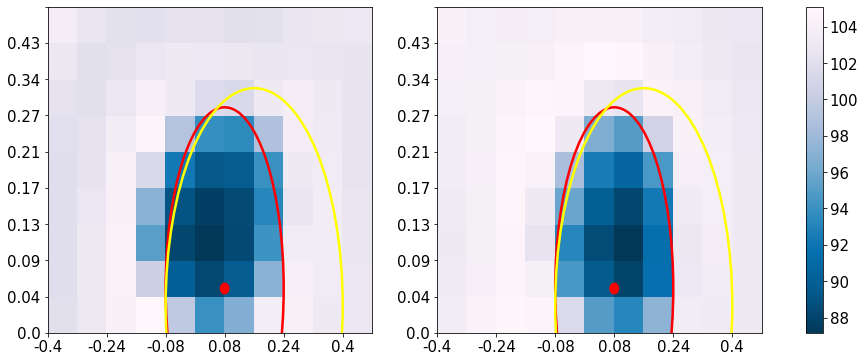

In [3219]:
def plot_heatmap(x1, next_x_lipm, next_x_bullet, terr_1, dqs_1, dqs_2, env):
    plt.rcParams.update({'font.size': 15})
    q_1 = dqs_1.predict_q(x1, terr_1)[0]
    q_2 = dqs_2.predict_q(x1, terr_1)[0]
    n = dqs_1.no_actions
    q_mat = np.zeros((n[1], n[0]))
    
    for i in range(len(q_1)):
        q_mat[int(dqs_1.x_in[i,9]), int(dqs_1.x_in[i,8])] = q_1[i]
    fig, ax = plt.subplots(1,2, figsize = (16, 6))
    ax[0].set_xticklabels(env.action_space_x[::2])
    ax[0].set_yticklabels(env.action_space_y)
    heatmap = ax[0].pcolor(q_mat, cmap='PuBu_r')
    
#     n = dqs.no_actions
#     q_mat = np.zeros((n[1], n[0]))
#     for i in range(len(q_1)):
#         q_mat[int(dqs.x_in[i,9]), int(dqs.x_in[i,8])] = q_1[i]
    
    
    rad = infinite_capture_radius(0.2, env.action_space_x[-1], env.h)
#     print(rad, dcm_x, dcm_y)
    
    dcm_x = compute_dcm([next_x_lipm[0], next_x_lipm[3]], env.h)
    dcm_y = compute_dcm([next_x_lipm[1], next_x_lipm[4]], env.h)
    
    discretization_x = env.action_space_x[1] - env.action_space_x[0]
    discretization_y = env.action_space_y[1] - env.action_space_y[0]
        
    capture_region = Ellipse(( dcm_x/discretization_x + 5, dcm_y/discretization_y), \
                                2*(rad//(discretization_x)), 2*(rad//(discretization_y)), fill = False, color = 'red', lw = 2.5)
    
    dcm = plt.Circle(( dcm_x/discretization_x + 5, dcm_y/discretization_y), \
                                0.15, fill = True, color = 'red')

    kin_region = Ellipse((next_x_lipm[0]/discretization_x + 6, next_x_lipm[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//discretization_y), fill = False, color = 'yellow', lw = 2.5)
        
    ax[0].add_patch(capture_region)
    ax[0].add_patch(kin_region)
    ax[0].add_patch(dcm)
    
    for i in range(len(q_2)):
        q_mat[int(dqs_2.x_in[i,9]), int(dqs_2.x_in[i,8])] = q_2[i]
    ax[1].set_xticklabels(env.action_space_x[::2])
    ax[1].set_yticklabels(env.action_space_y)
    heatmap = ax[1].pcolor(q_mat, cmap='PuBu_r')
    
    dcm_x = compute_dcm([next_x_bullet[0], next_x_bullet[3]], env.h)
    dcm_y = compute_dcm([next_x_bullet[1], next_x_bullet[4]], env.h)
    
    discretization_x = env.action_space_x[1] - env.action_space_x[0]
    discretization_y = env.action_space_y[1] - env.action_space_y[0]
        
    capture_region = Ellipse(( dcm_x/discretization_x + 5, dcm_y/discretization_y), \
                                2*(rad//(discretization_x)), 2*(rad//(discretization_y)), fill = False, color = 'red', lw = 2.5)
    
    dcm = plt.Circle(( dcm_x/discretization_x + 5, dcm_y/discretization_y), \
                                0.15, fill = True, color = 'red')

    kin_region = Ellipse((next_x_bullet[0]/discretization_x + 6, next_x_bullet[1]/discretization_y),\
                            2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//discretization_x),\
                         2*(np.sqrt(env.max_leg_length**2 - (env.h - env.com_offset)**2)//discretization_y), fill = False, color = 'yellow', lw = 2.5)
    
    ax[1].add_patch(capture_region)
    ax[1].add_patch(kin_region)
    ax[1].add_patch(dcm)

    fig.colorbar(heatmap, ax=ax)
    plt.show()


dqs_1 = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_11_9')
dqs_2 = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_1_vel')
    
    
x1 = [0.0, 0.02, 0.34, 0.0, 0.0, 1, 0, 0]
action =  [ 5. ,4. ,  -0.01]

x1_next_lipm = [0.00, 0.03, 0.33, 0.0, 0.1, -1., 0, 0]
x1_next_bullet = [0.00, 0.03, 0.33, 0.0, 0.1, -1., 0, 0]

x1_next_lipm[0] += env.action_space_x[int(history['action'][i][0])]
# x1_next_lipm[1] += x1[5]*env.action_space_y[history['action'][i][1]] + 0.13/2.0

x1_next_bullet[0] += env.action_space_x[int(history['action'][i][0])]
# x1_next_bullet[1] += x1[5]*env.action_space_y[history['action'][i][1]] + 0.13/2.0

terrain_1 = -0.0*(np.random.randint(-4, 5, no_actions[0]*no_actions[1]))/4.0

plot_heatmap(x1, x1_next_lipm, x1_next_bullet, terrain_1, dqs_1, dqs_2, env)
